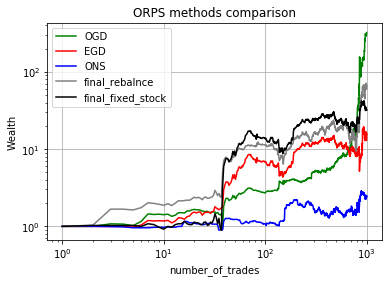

In [3]:
import numpy as np
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from scipy.io import loadmat
import copy

#calculating the loss
def loss(x, r_t):
    return -np.log(np.dot(x, r_t))

# revanue in time t
def revanue(x_revanue, r_t, wealth):
    temp = wealth* (np.dot(np.transpose(x_revanue), r_t))
    return temp

# normalize vector
def normalize_func(x_normalize_func):
    sum_x = np.sum(x_normalize_func)
    x_normalize_func = x_normalize_func/sum_x
    return x_normalize_func

# gradient vector
def gradient(x_gradient, r_t):
    temp = -1/np.dot(np.transpose(r_t), x_gradient)
    temp = np.dot(temp,np.transpose(r_t))
    return temp


#get r materix
def get_r_matrix(number_of_stocks, number_of_trades, stocks):
    r_matrix = np.zeros([int(number_of_stocks/2), number_of_trades-1])
    for stock in range(int(number_of_stocks/2)):
        for trade in range(number_of_trades-1):
            r_matrix[stock][trade] = (stocks['A'][stock][trade + 1])/(stocks['A'][stock][trade])
    reverse_matrix = reverse_get_r_matrix(number_of_stocks, number_of_trades, stocks)
    new = np.concatenate((r_matrix, reverse_matrix), axis=0)
    return new

def reverse_get_r_matrix(number_of_stocks, number_of_trades, stocks):
    r_matrix = np.zeros([int(number_of_stocks/2), number_of_trades-1])
    for stock in range(int(number_of_stocks/2)):
        for trade in range(number_of_trades-1):
            r_matrix[stock][trade] = (stocks['A'][stock][trade ])/(stocks['A'][stock][trade+ 1])
    return r_matrix

#simplex projection
def proj(temp_x, number_of_stocks):
    y_flipsort = np.flipud(np.sort(temp_x))
    cumsum = np.cumsum(y_flipsort)
    t = (cumsum - 1) / np.arange(1, number_of_stocks + 1).astype('float')
    temp_t = t[:-1]
    y_iter = y_flipsort[1:]
    if np.all((temp_t - y_iter) < 0):
        x_proj = temp_x - t[-1]
    else:
        x_proj = temp_x - temp_t[np.searchsorted(temp_t - y_iter, 0, side='left')]
    x_proj[x_proj < 0.] = 0.
    sum_x = np.sum(x_proj)
    x_proj = x_proj/sum_x
    return x_proj

#plot
def plot(final_OGD, final_EGD, final_ONS, final_rebalnce, final_fixed_stock, number_of_trades):
    if final_OGD is not 0:
        plt.plot(range(1, number_of_trades+1), final_OGD , 'green')
    if final_EGD is not 0:
        plt.plot(range(1, number_of_trades+1), final_EGD , 'red')
    if final_ONS is not 0:
        plt.plot(range(1, number_of_trades+1), final_ONS , 'blue')
    if final_rebalnce is not 0:
        plt.plot(range(1, number_of_trades+1), final_rebalnce , 'grey')
    if final_fixed_stock is not 0:
        plt.plot(range(1, number_of_trades+1), final_fixed_stock , 'black')

    plt.legend(['OGD', 'EGD', 'ONS'
                , 'final_rebalnce', 'final_fixed_stock'], loc='best')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.ylabel('Wealth')
    plt.xlabel('number_of_trades')
    plt.title('ORPS methods comparison')
    plt.savefig('ORPS methods comparison.png')
    plt.show()
    
#fixed stock func
def fixed_stock_func(number_of_stocks, number_of_trades, r_matrix):
    all_stocks_wealth = np.zeros([number_of_stocks, number_of_trades])
    for stock in range(number_of_stocks):
        for trade in range(number_of_trades):
            if (trade == 0):
                all_stocks_wealth[stock][trade] = 1
                continue
            all_stocks_wealth[stock][trade] = all_stocks_wealth[stock][trade-1] * r_matrix[stock][trade-1]
    max = None
    index = None
    for stock in range(number_of_stocks):
        if ((max == None) or (all_stocks_wealth[stock][number_of_trades-1]>max)):
            max = all_stocks_wealth[stock][number_of_trades-1]
            index = stock    
    return all_stocks_wealth[index, :]

def grad_rebalnce(R, x_grad_rebalnce):
    instence_number_of_trades,temp = R.shape
    a = np.dot(R, x_grad_rebalnce)
    a = - 1 / a
    a = np.reshape(a, (instence_number_of_trades, -1))
    return np.sum(R * a, axis=0)

def fit(R, number_of_stocks, number_of_trades, max_iter, eta_min):
    I = np.eye(number_of_stocks, dtype=np.float32)
    x_fit = I[0]
    for t in range(1, max_iter + 1):
        eta = 2 / (1 + t)
        if eta < eta_min:
            break
        i_min = np.argmin(grad_rebalnce(R, x_fit))
        x_fit += eta * (I[i_min] - x_fit)
    return x_fit        

def rebalnce_solution(number_of_trades, r_matrix, number_of_stocks):
    max_iter = 25
    eta_min=0.
    R = np.transpose(r_matrix)
    x_rebalnce_solution = np.empty_like(R)
    for t in range(R.shape[0]):
        x_rebalnce_solution[t] = fit(R[0:t+1], number_of_stocks, number_of_trades, max_iter, eta_min)
    x_rebalnce_solution = x_rebalnce_solution[-1]
    return x_rebalnce_solution

def rebalnce_score(x_rebalnce_score, number_of_trades, r_matrix):
    score = np.zeros(number_of_trades)
    score[0] = 1
    for trade in range (1, number_of_trades):
        score[trade] = score[trade-1] * np.dot(x_rebalnce_score, r_matrix[:,trade-1])
    return score

#Online_gradient_descent
def Online_gradient_descent(x_OGD, r_matrix, number_of_trades, number_of_stocks, step):
    scores_OGD = np.zeros(number_of_trades)
    scores_OGD[0] = 1
    scores_OGD[1] = revanue(x_OGD, r_matrix[:,0], scores_OGD[0])
    for i in range(2, number_of_trades):
        x_OGD = x_OGD - (step * gradient(x_OGD,r_matrix[:,i-2]))
        x_OGD = proj(x_OGD, number_of_stocks)
        scores_OGD[i] = revanue(x_OGD, r_matrix[:,i-1], scores_OGD[i-1])
    return scores_OGD

#denominator of the equation
def exp_stocks_t(x_exp_stocks_t, rt, number_of_stocks, step, grad):
    sum = 0
    for stock in range(number_of_stocks):
        sum += x_exp_stocks_t[stock]* np.exp(-step*grad[stock])
    return sum

#Online Exponentiated Gradient
def Online_Exponentiated_Gradient(x_EGD, r_matrix, number_of_trades, number_of_stocks, step):
    scores_OEG = np.zeros(number_of_trades)
    scores_OEG[0] += 1
    scores_OEG[1] = revanue(x_EGD, r_matrix[:,0], scores_OEG[0])    
    for i in range(2, number_of_trades):
        grad = gradient(x_EGD,r_matrix[:,i-2])
        denominator = exp_stocks_t(x_EGD, r_matrix[:,i-2], number_of_stocks, step, grad)
        for stock in range(number_of_stocks): 
            x_EGD[stock] = (x_EGD[stock] * np.exp(-step * grad[stock])) / denominator
        x_EGD = proj(x_EGD, number_of_stocks)
        scores_OEG[i] += revanue(x_EGD, r_matrix[:,i-1], scores_OEG[i-1])
    return scores_OEG
#projection on yt+1
def projection(A, y, number_of_stocks, number_of_trades):
    I = np.eye(number_of_stocks)
    x_projection = I[0]
    for trade in range(1, int(number_of_trades/10)):
        step = 2 / (1 + trade)
        grad = 2 * np.dot(A, x_projection - y)
        temp_y = I[np.argmin(grad)]
        x_projection += step * (temp_y - x_projection)
    return x_projection

#online_newton_step
def online_newton_step(number_of_trades, number_of_stocks, r_matrix, x_ONS, D, G):
    gamma = 0.5 *  min(1 / (4 * G * D), 2)
    epsilion = 1 / ((gamma ** 2) * (D**2))
    A = np.empty((number_of_stocks,number_of_stocks))
    np.fill_diagonal(A, epsilion)
    scores_ONS = np.zeros(number_of_trades)
    r_t = r_matrix[ : , 0]
    scores_ONS[0] = 1
    scores_ONS[1] = revanue(x_ONS, r_t, scores_ONS[0])
    for t in range(2,number_of_trades):
        grad_t = gradient(x_ONS, r_matrix[ : , t-2])
        r_t = r_matrix[ : , t-1]
        grad_matrix = np.outer(grad_t, grad_t)
        A = A + grad_matrix
        y_t = x_ONS - (1/gamma)*np.dot(np.linalg.inv(A),grad_t)
        x_ONS = projection(A, y_t, number_of_stocks, number_of_trades)
        x_ONS = normalize_func(x_ONS)
        scores_ONS[t] = revanue(x_ONS, r_t, scores_ONS[t-1])
    return scores_ONS

def main():
    #parameters
    stocks = loadmat('data/data_490_1000.mat')

    stocks_shape = stocks['A'].shape
    number_of_stocks = stocks_shape[0]*2
    number_of_trades = stocks_shape[1]
    final_OGD = np.zeros(number_of_trades)
    final_EGD = np.zeros(number_of_trades)
    final_ONS = np.zeros(number_of_trades)
    final_rebalnce = np.zeros(number_of_trades)
    final_fixed_stock = np.zeros(number_of_trades)
    x = np.random.uniform(0,10,number_of_stocks)
    x = normalize_func(x)
    r_matrix = get_r_matrix(number_of_stocks, number_of_trades, stocks)
    T = number_of_trades
    D = math.sqrt(2)
    G = np.max(np.linalg.norm(np.transpose(r_matrix), axis=1) / np.sum(np.transpose(r_matrix), axis=1))
    OGD_step = D / (G * math.sqrt(T))
    EGD_step = np.log(number_of_stocks)/(G*np.sqrt(2*number_of_trades))

    x_OGD = copy.deepcopy(x)
    OGD = Online_gradient_descent(x_OGD, r_matrix, number_of_trades, number_of_stocks, OGD_step)
    x_EGD = np.empty(number_of_stocks)
    x_EGD.fill(1/number_of_stocks)
    EGD = Online_Exponentiated_Gradient(x_EGD, r_matrix, number_of_trades, number_of_stocks, EGD_step)
    x_ONS = copy.deepcopy(x)
    ONS = online_newton_step(number_of_trades, number_of_stocks, r_matrix, x_ONS, D, G)
    temp_x = rebalnce_solution(number_of_trades, r_matrix, number_of_stocks)
    rebalnce = rebalnce_score(temp_x, number_of_trades, r_matrix)
    fixed_stock = fixed_stock_func(number_of_stocks, number_of_trades, r_matrix)

    final_OGD += OGD
    final_EGD += EGD
    final_ONS += ONS
    final_rebalnce += rebalnce
    final_fixed_stock += fixed_stock

    plot(final_OGD, final_EGD, final_ONS, final_rebalnce, final_fixed_stock, number_of_trades)

if __name__ == "__main__":
    main()